# Parameter estimation and hypothesis testing

In [1]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact
%matplotlib inline
sns.set()

## From Bayes Theorem to Bayesian Inference

Let's say that we flip a biased coin several times and we want to estimate the probability of heads from the number of heads we saw. Statistical intuition tells us that our best estimate of $p(heads)=$ number of heads divided by total number of flips.

However, 

1. It doesn't tell us how certain we can be of that estimate and
2. This type of intuition doesn't extend to even slightly more complex examples.

Bayesian inference helps us here. We can calculate the probability of a particular $p(H)$ given data $D$ by setting $A$ in Bayes Theorem equal to $p$ and $B$ equal to $D$.


$$P(p|D) = \frac{P(D|p)P(p)}{P(D)} $$



* Explain the above and why we don't currently need to consider $P(D)$ to get

$$P(p|D) \propto P(D|p)P(p) $$

* Discuss & define _prior_, _likelihood_ and _posterior_. 
* Essential: we get the whole distribution of $P(p|D)$, not merely a point estimate plus errors bars.
* Show analytic solution for posterior when flipping coins.
* Now let's generate some coin flips and try to estimate $p(H)$. **Note:** $0\leq p\leq 1$.

In [2]:
def plot_posterior(p=0.6, N=0):
    """Plot the posterior given a uniform prior; Bernoulli trials
    with probability p; sample size N"""
    np.random.seed(42)
    # Flip coins 
    n_successes = np.random.binomial(N, p)
    # X-axis for PDF
    x = np.linspace(0, 1, 100)
    #prior
    prior = 1
    posterior = x**n_successes*(1-x)**(N-n_successes)*prior
    posterior /= np.max(posterior)  # so that peak always at 1
    plt.plot(x, posterior)
    plt.show()

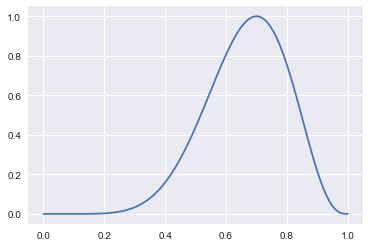

In [3]:
plot_posterior(N=10)

* Now use the great ipywidget interact to check out the posterior as you generate more and more data (you can also vary $p$):

In [4]:
interact(plot_posterior, p=(0, 1, 0.01), N=(0, 100));

Things to note and to discuss as a group

* as you generate more and more data, your posterior gets narrower, i.e. you get more and more certain of your estimate.
* you need more data to be certain of your estimate when $p=0.5$, as opposed to when $p=0$ or $p=1$. 

### Other priors

But wait! We've had to specify a prior. Discuss specification of priors. Motivate Jeffries prior and show equation for it. 

### Hands-on

* Create an interactive plot like the one above, except that it has two posteriors on it: one for the uniform prior, another for the Jeffries prior.

In [5]:
# Solution
def plot_posteriors(p=0.6, N=0):
    np.random.seed(42)
    n_successes = np.random.binomial(N, p)
    x = np.linspace(0.01, 0.99, 100)
    posterior1 = x**n_successes*(1-x)**(N-n_successes)  # w/ uniform prior
    posterior1 /= np.max(posterior1)  # so that peak always at 1
    plt.plot(x, posterior1, label='Uniform prior')
    jp = np.sqrt(x*(1-x))**(-1)  # Jeffreys prior
    posterior2 = posterior1*jp  # w/ Jeffreys prior
    posterior2 /= np.max(posterior2)  # so that peak always at 1 (not quite correct to do; see below)
    plt.plot(x, posterior2, label='Jeffreys prior')
    plt.legend()
    plt.show()

In [6]:
interact(plot_posteriors, p=(0, 1, 0.01), N=(0, 100));

**Question:** What happens to the posteriors as you generate more and more data?

## Parameter estimation II: the mean of a population



### Hands-on

In this exercise, you'll calculate the  posterior mean beak depth of Galapagos finches. To do so, you'll assume that you know the population variance. 
[I'll take them through the equations and the pseudo-code of how to do this]

## Bayesian Hypothesis testing

### Instruction: A/B tests on click through rates

### Hands-on: beak shape difference over 50 years in Galapagos finches